In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
import nltk
import numpy as np
import math
from collections import Counter
from collections import defaultdict
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
nltk.download('brown')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
path = 'GoogleNews-vectors-negative300.bin'
word2vec= KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
start_token = '^'
end_token = '$'
tagged_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')

In [5]:
result=[]
for i in range(len(tagged_sentences)):
    temp=[]
    sentence = tagged_sentences[i]
    temp.append((start_token,start_token))
    for word,tag in sentence:
        temp.append((word.lower(),tag))
    temp.append((end_token,end_token))
    result.append(temp)

tagged_sentences = result

In [6]:
def vec_of_tags(Sentences):
    tag_value = {'.':0, 'ADJ':1, 'ADP':2, 'ADV':3, 'CONJ':4, 'DET':5, 'NOUN':6, 'NUM':7, 'PRON':8, 'PRT':9, 'VERB':10, 'X':11, '^':12, '$':13}
    vec_of_tags = np.zeros((14,300))
    for sentence in Sentences:
        for word,tag in sentence:
            try:
                vec_of_tags[tag_value[tag]] += word2vec[word]
            except KeyError:
                pass
    return vec_of_tags

In [7]:
# for Checking the vec_of_tags
# checking_word = word2vec['ram']
# tag_value = {'.':0, 'ADJ':1, 'ADP':2, 'ADV':3, 'CONJ':4, 'DET':5, 'NOUN':6, 'NUM':7, 'PRON':8, 'PRT':9, 'VERB':10, 'X':11, '^':12, '$':13}
# vec = vec_of_tags(tagged_sentences)
# print(cosine_similarity([checking_word,vec[tag_value['NOUN']]])[0][1])

In [8]:
def Training(sentences):
    list_of_all_tuples = []
    for sentence in sentences:
        for word,tag in sentence:
            list_of_all_tuples.append((word,tag))
    POS_tag_counts = Counter(tag for word,tag in list_of_all_tuples)
    word_pos_tags = defaultdict(Counter)
    for word,pos_tag in list_of_all_tuples:
        word_pos_tags[word][pos_tag]+=1
    Tag_transition_count = defaultdict(Counter)
    for sentence in sentences:
        for i in range(len(sentence)-1):
            Tag_transition_count[sentence[i][1]][sentence[i+1][1]]+=1

    return POS_tag_counts,word_pos_tags,Tag_transition_count

In [9]:
#probability of tag2 given tag1
def transition_probability(tag1,tag2,POS_tag_counts,Tag_transition_count):
    tag1_tag2 = Tag_transition_count[tag1][tag2]
    tag1_total = POS_tag_counts[tag1]
    res = (tag1_tag2) / (tag1_total) 
    if(res==0):
        res = 10**-9
    return res

In [10]:
def lexical_probability(word,tag,POS_tag_counts,word_pos_tags,vec):
    tag_value = {'.':0, 'ADJ':1, 'ADP':2, 'ADV':3, 'CONJ':4, 'DET':5, 'NOUN':6, 'NUM':7, 'PRON':8, 'PRT':9, 'VERB':10, 'X':11, '^':12, '$':13}
    word_total = sum(word_pos_tags[word].values())
    
    word_tag = word_pos_tags[word][tag]
    tag_total = POS_tag_counts[tag]
    
    if word_total==0:
        try:
            checking_word = word2vec[word]
            res = math.exp(cosine_similarity([checking_word,vec[tag_value[tag]]])[0][1]-1)
        except KeyError:
            res = 10**-9
    else:
        res = word_tag/tag_total
    if res<=0:
        res = 10**-9
    return res

In [11]:
def Viterbi_Algorithm(untagged_sentence,POS_tag_counts,word_pos_tags,Tag_transition_count,vec):
    n = len(untagged_sentence)
    prev = defaultdict(Counter)
    curr = defaultdict(Counter)
    parent = defaultdict(Counter)
    for tag in POS_tag_counts:
        prev[tag] = 0.0
    prev[start_token]=0.0
    parent[0][start_token] = 0

    for i in range(1,n-1):
        word = untagged_sentence[i]
        for tag in POS_tag_counts:
            curr[tag] = 1.0
            for prev_tag in POS_tag_counts:
                temp = prev[prev_tag] + math.log(lexical_probability(word,tag,POS_tag_counts,word_pos_tags,vec)) + math.log(transition_probability(prev_tag,tag,POS_tag_counts,Tag_transition_count))
                if curr[tag]==1.0 or temp>curr[tag]:
                    curr[tag] = temp
                    parent[i][tag] = prev_tag
        for tag in POS_tag_counts:
            prev[tag] = curr[tag]

    final_tags = ['$' for i in range(n)]
    for tag in POS_tag_counts:
        if curr[tag] > curr[final_tags[n-2]]:
            final_tags[n-2] = tag
    for i in range(n-3,0,-1):
        final_tags[i] = parent[i+1][final_tags[i+1]]
    final_tags[0] = start_token
    return final_tags


In [12]:
Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count = defaultdict(Counter), defaultdict(Counter), defaultdict(Counter)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
tagged_sentences = np.array(tagged_sentences,dtype='object')
y_pred_list = []
y_true_list = []
final_vec=0
for fold, (train, test) in enumerate(kfold.split(tagged_sentences)):
    train_sentences = tagged_sentences[train]
    test_sentences = tagged_sentences[test]
    POS_tag_counts,word_pos_tags,Tag_transition_count = Training(train_sentences)
    vec = vec_of_tags(train_sentences)
    if(fold==3):
        Last_POS_tag_counts = POS_tag_counts
        Last_word_pos_tags = word_pos_tags
        Last_Tag_transition_count = Tag_transition_count
        final_vec = vec
    y_pred = []
    y_true = []

    for sentence in test_sentences:
        untagged_sentence = [word for word,tag in sentence]
        prediction = Viterbi_Algorithm(untagged_sentence,POS_tag_counts,word_pos_tags,Tag_transition_count,vec)
        for i in range(1,len(prediction)-1):
            y_pred.append(prediction[i])
            y_true.append(sentence[i][1])

    y_pred_list.append(np.array(y_pred))
    y_true_list.append(np.array(y_true))
    accuracy = accuracy_score(y_true_list[-1],y_pred_list[-1],normalize=True)
    print(f'Accuracy for Fold {fold + 1} : {accuracy}')


Accuracy for Fold 1 : 0.9606205712663113
Accuracy for Fold 2 : 0.9607147016827929
Accuracy for Fold 3 : 0.9603002860891824
Accuracy for Fold 4 : 0.9610214476520962
Accuracy for Fold 5 : 0.9600954876474728


In [13]:
f0_5_score=0
f1score=0
f2score=0
precision = 0
recall = 0
for i in range(5):
    f0_5_score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=0.5,average='weighted',zero_division=0)
    f1score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=1,average='weighted',zero_division=0)
    f2score+=fbeta_score(y_true_list[i],y_pred_list[i],beta=2,average='weighted',zero_division=0)
    precision+=precision_score(y_true_list[i],y_pred_list[i],average='weighted',zero_division=0)
    recall+=recall_score(y_true_list[i],y_pred_list[i],average='weighted',zero_division=0)
f0_5_score = f0_5_score/5.0
f1score = f1score/5.0
f2score = f2score/5.0
precision = precision/5.0
recall = recall/5.0

print(f'Precision : {precision}')
print(f'Recall : {recall}')
print(f'F0.5 Score : {f0_5_score}')
print(f'F1 Score : {f1score}')
print(f'F2 Score : {f2score}')

Precision : 0.9604942731149146
Recall : 0.960550498867571
F0.5 Score : 0.960467122841927
F1 Score : 0.9604629662664248
F2 Score : 0.9605015364677237


In [14]:
def classification_report_function(y_true_list,y_pred_list):
    classes = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    report_final = np.zeros((12,3))
    support = 0
    for i in range(5):
        report = np.zeros((12,3))
        cr = classification_report(y_true_list[i],y_pred_list[i],labels=classes,zero_division=0)
        cr = cr.replace('macro avg', 'macro')
        cr = cr.replace('micro avg', 'micro')
        cr = cr.replace('weighted avg', 'weighted')
        cr = cr.replace('\n\n', '\n')
        lines = cr.split('\n')
        mat , sup = [], []
        for k in range(12):
            line = lines[k+1]
            a = line.strip().split()
            report[k][0] = float(a[1])
            report[k][1] = float(a[2])
            report[k][2] = float(a[3])
            sup.append(float(a[-1]))
        sup = np.array(sup)
        if(i==0):
            report_final = report
            support = sup
        else:
            report_final+=report
            support+=sup
    report_final = report_final/5.0
    support = support/5.0
    xticklabels = ['Precision', 'Recall', 'F1-Score']
    yticklabels = ['{0}[{1}]'.format(classes[i], sup_i) for i, sup_i in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.imshow(report_final, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels)
    plt.yticks(np.arange(len(classes)), yticklabels)
    for i in range(report.shape[0]):
        for j in range(report.shape[1]):
            plt.text(j, i, format(report[i, j], '.2f'), horizontalalignment="center", verticalalignment="center" ,fontsize=14)

In [22]:
def classification_report_function1(y_true_list,y_pred_list):
    tagset = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    report = 0
    support = 0
    check = 0
    for i in range(5):
        cr = classification_report(y_true_list[i],y_pred_list[i],labels=tagset,zero_division=0)
        cr = cr.replace('macro avg', 'macro')
        cr = cr.replace('micro avg', 'micro')
        cr = cr.replace('weighted avg', 'weighted')
        cr = cr.replace('\n\n', '\n')
        lines = cr.split('\n')
        classes , mat , sup = [], [], []
        for line in lines[1:]:
            a = line.strip().split()
            if len(a) < 2:
                continue
            temp = [float(x) for x in a[1: len(a) - 1]]
            sup.append(int(a[-1]))
            classes.append(a[0])
            mat.append(temp)
        mat = np.array(mat)
        sup = np.array(sup)
        if(i==0):
            report = mat
            support = sup
        else:
            report+=mat
            support+=sup
    report = report/5.0
    support = support/5.0
    xticklabels = ['Precision', 'Recall', 'F1-Score']
    yticklabels = ['{0}[{1}]'.format(classes[i], sup_i) for i, sup_i in enumerate(support)]
    plt.clf()
    fig, ax = plt.subplots(figsize=(18,10))
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_tick_params(labelsize=15)
    ax.yaxis.set_tick_params(labelsize=15)
    plt.imshow(report, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels)
    plt.yticks(np.arange(len(classes)), yticklabels)
    for i in range(report.shape[0]):
        for j in range(report.shape[1]):
            plt.text(j, i, format(report[i, j], '.2f'), horizontalalignment="center", verticalalignment="center" ,fontsize=14)
    
    plt.savefig('classification_report.png')


In [23]:
def confusion_matrix_function(y_true_list,y_pred_list):
    list_of_tags = ['.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']
    count = 0
    mat = 0
    for y_true,y_pred in zip(y_true_list,y_pred_list):
        cm = confusion_matrix(y_true,y_pred,labels=list_of_tags)
        count += 1
        if(count==1):
            mat = cm
        else:
            mat += cm

    mat = mat.astype('float')
    mat = mat/count
    mat_confusion_matrix = mat/np.sum(mat, axis=1, keepdims=True) #With Normalization
    #mat_confusion_matrix = mat  #Without Normalization
    plt.clf()
    fig, ax = plt.subplots(figsize=(12,10))
    tick_marks = np.arange(len(list_of_tags))
    plt.xticks(tick_marks, list_of_tags)
    plt.yticks(tick_marks, list_of_tags)
    for i in range(mat_confusion_matrix.shape[0]):
            for j in range(mat_confusion_matrix.shape[1]):
                plt.text(j, i, format(mat_confusion_matrix[i, j], '0.2f'), horizontalalignment="center")
    plt.imshow(mat_confusion_matrix,interpolation='nearest',cmap=plt.cm.cool)
    plt.colorbar()
    plt.savefig('confusion_matrix.png')

<Figure size 432x288 with 0 Axes>

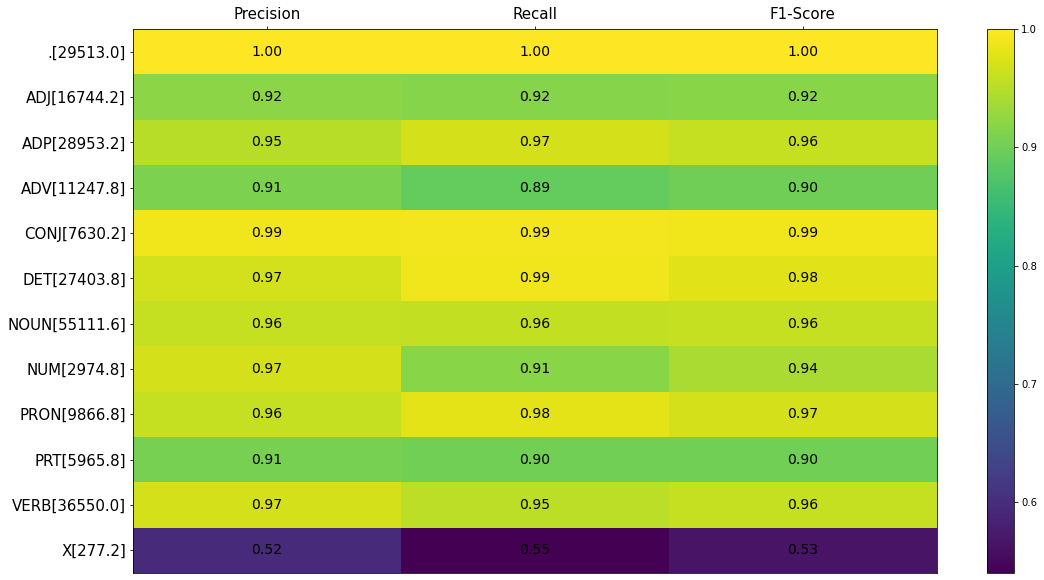

In [24]:
classification_report_function(y_true_list,y_pred_list)

<Figure size 432x288 with 0 Axes>

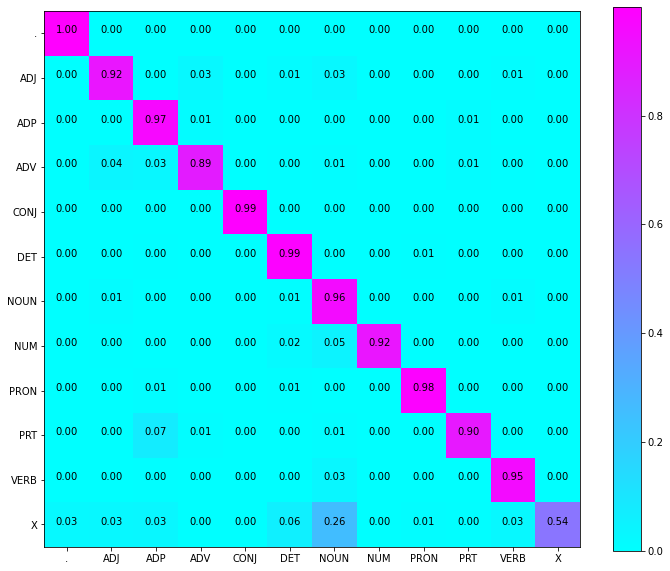

In [25]:
confusion_matrix_function(y_true_list,y_pred_list)

In [ ]:
def sentence_checking(untagged_sentence,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count,final_vec):
    untagged_sentence = untagged_sentence.lower()
    sentence_list = untagged_sentence.split()
    sentence_list = ['^'] + sentence_list + ['$']
    
    print(Viterbi_Algorithm(sentence_list,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count,final_vec))

In [ ]:
for_checking = 'I play Football with Ram'
sentence_checking(for_checking,Last_POS_tag_counts,Last_word_pos_tags,Last_Tag_transition_count,final_vec)